# Does the macroeconomy exhibit recurring patterns? —— A MacroScope Model to quantify the business cycle

**Team Member**
| Name | Student Number |
| :----: | :--------------: |
| Ruiyang Ge | 2301212326 |
| Yuhang Qin | 2301212373 |
| Yuyang Zhang | 2301212424 |
| Yichao Chen | 2301212314 |

As an ancient Chinese saying goes, 'Use history as a mirror.' We aim to use the DTW method to measure the correlation between the current month and previous months in history. By analyzing the future asset price changes of the months with the strongest historical correlations, we can select the optimal investment strategy.

And first, we will give a brief introdution to **Dynamic Time Warping (DTW)**

**Dynamic Time Warping (DTW)** is an algorithm used to measure similarity between two time series. Unlike traditional distance measures like Euclidean distance, which assume that the two time series are aligned in time, DTW allows for the comparison of time series that are out of phase or that may vary in speed. It can "warp" the time axis to find the best alignment between the two series.

### DTW Formula:
DTW calculates the distance between two time series, `X = {x1, x2, ..., xn}` and `Y = {y1, y2, ..., yn}`, by considering the optimal match between points in `X` and `Y` that minimizes the distance over the entire sequence. The core of the algorithm uses dynamic programming to find this optimal alignment.

The DTW distance `D(i, j)` between two time points `i` from series `X` and `j` from series `Y` is given by:

$$
D(i, j) = \text{dist}(X_i, Y_j) + \min
\begin{cases}
D(i-1, j), \\
D(i, j-1), \\
D(i-1, j-1)
\end{cases}
$$

Where:
- `dist(X_i, Y_j)` is the cost (or distance) between `X_i` and `Y_j`, typically calculated as squared differences (Euclidean distance).
- The recurrence relation defines the optimal path through the matrix by minimizing the accumulated distance.

The final DTW distance is the accumulated distance at the bottom-right corner of the matrix, `D(n, m)`, where `n` and `m` are the lengths of the time series `X` and `Y`.

### Key Points:
- **Alignment**: DTW allows sequences of different lengths to be compared by stretching and compressing the time axis.
- **Non-linear warping**: DTW can adjust the time axis, meaning that the series can shift in time to align better.
- **Dynamic programming**: The algorithm uses dynamic programming to compute the best alignment path in quadratic time complexity (`O(n*m)`).

DTW is particularly useful for time series data where the temporal order of events may not be identical between series, such as in speech recognition, financial time series, and signal processing.


In [10]:
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

Last week, we found some data covering various aspects (such as **inflation**, **liquidity**, etc.). However, most of the data we found is **monthly** or **weekly frequency**. The **DTW method**, in order to compare correlations between months, requires **higher-frequency data**, ideally **daily data**. Therefore, we have searched for some **alternative data** here. 

It is important to note that our approach is still based on the framework of the data we found last week, so the data here is **merely for reference**. 

The data used here includes the following:

- **10-year China Government Bond Yield**
- **CSI 300**
- **CSI 2000**
- **USDCNH**
- **Nanhua Industrial Index**
- **Nanhua Commodity Index**
- **Total A-share turnover** 

The data covers **interest rates**, **stock indices**, **exchange rates**, **commodity indices**, **liquidity**, etc.

For our future approach, one idea we have is to use machine learning(RNN) methods to predict data such as **CPI** at the **daily frequency** level. We are currently in the process of **collecting data** to perform similar operations.

In [53]:
df = pd.read_excel(r'C:\QPS\Project\data.xlsx',skiprows=1)
df.head()

,date,10-year China Government Bond Yield,CSI 300,CSI 2000,USDCNH,Nanhua Industrial Index,Nanhua Commodity Index,Total A-share turnover
0,2012-05-02,3.5449,2683.487,3874.242,6.3058,2167.6312,1404.5997,205.552307
1,2012-05-03,3.5454,2691.518,3892.933,6.3034,2150.1195,1394.5464,178.913143
2,2012-05-04,3.5512,2715.879,3924.256,6.3050,2155.5663,1398.6172,183.306069
3,2012-05-07,3.5518,2717.778,3954.183,6.3090,2130.3329,1385.4007,197.308141
4,2012-05-08,3.5520,2709.116,3958.420,6.3082,2130.2201,1384.7851,187.819727


Here are the DTW distances between each variable in January 2025 and the variables from previous months.

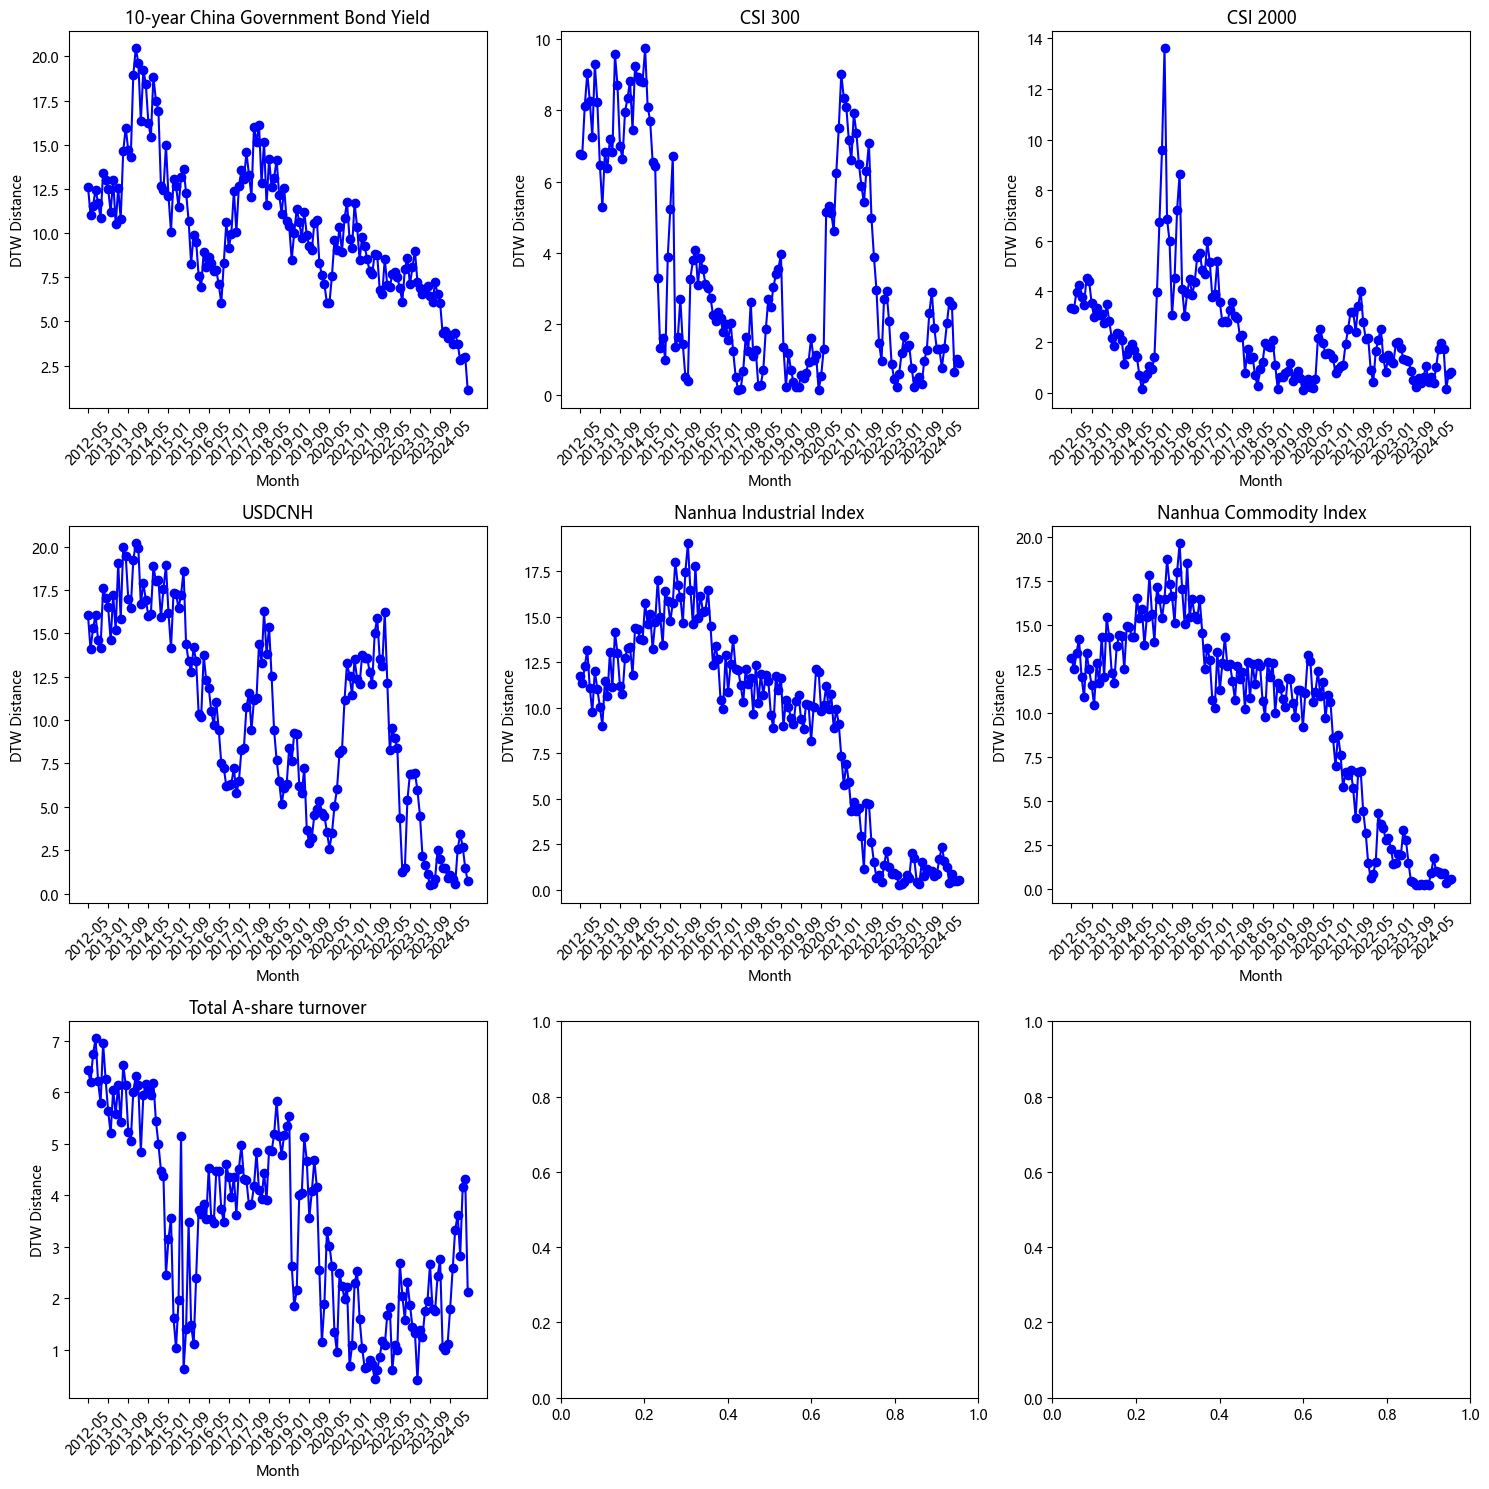

In [56]:
import pandas as pd
import numpy as np
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])
# Select only the numeric columns for standardization (excluding 'date')
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Initialize the scaler
scaler = MinMaxScaler()

# Apply standardization to only numeric columns
standardized_data = scaler.fit_transform(df[numeric_columns])

# Create a new DataFrame with standardized values and keep the 'date' column
standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns, index=df['date'])

# Reset the index to make 'date' a column again
standardized_df = standardized_df.reset_index()
# Group the data by month while keeping all the daily data for each month
monthly_data = standardized_df.groupby(pd.Grouper(key='date', freq='M'))

# Define the function to calculate DTW distance
def calculate_dtw(series1, series2):
    # Calculate the DTW distance if both series have more than 1 point
    if len(series1) > 1 and len(series2) > 1:
        distance, _ = fastdtw(series1, series2)
        return distance
    else:
        return None  # Return None if the series is too short

# Initialize an empty dictionary to store the results
dtw_results = {}

# Loop over each variable (column) in the DataFrame, and calculate DTW for each
for i, variable in enumerate(df.columns[1:]):  # Skip the 'date' column
    dtw_distances = []
    month_labels = []
    
    # Loop through each month starting from the second month (to compare with previous months)
    for end_month, end_data in monthly_data:
        if end_month <= pd.Timestamp('2025-01-31'):  # We want to compare until January 2025
            if end_month == pd.Timestamp('2025-01-31'):  # We are interested in January 2025
                # Get the time series for January 2025
                series1 = end_data[variable].values
                
                for start_month, start_data in monthly_data:
                    if start_month < end_month:  # Only compare with previous months
                        # Get the time series for the previous months
                        series2 = start_data[variable].values
                        distance = calculate_dtw(series1, series2)
                        if distance is not None:
                            dtw_distances.append(distance)
                            month_labels.append(start_month.strftime('%Y-%m'))  # Format the month label as 'yyyy-mm'

    # Add the results to the dictionary with the variable name as the key
    dtw_results[variable] = pd.Series(dtw_distances, index=month_labels)

# Convert the dictionary to a DataFrame
dtw_df = pd.DataFrame(dtw_results)
# 生成 3x3 的子图来显示每个变量的 DTW 距离
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# 遍历每个变量，为每个变量绘制图表
for i, variable in enumerate(dtw_df.columns):
    row = i // 3  # 确定行位置
    col = i % 3   # 确定列位置
    axes[row, col].plot(dtw_df.index, dtw_df[variable], marker='o', linestyle='-', color='b')
    axes[row, col].set_title(variable)
    axes[row, col].set_xlabel('Month')
    axes[row, col].set_ylabel('DTW Distance')

    # 设置每隔几个月显示一个标签
    axes[row, col].set_xticks(dtw_df.index[::8])  # 每隔8个月显示一个标签
    axes[row, col].tick_params(axis='x', rotation=45)  # 旋转x轴标签以更好地显示

# 调整布局
plt.tight_layout()
plt.show()

In [57]:
dtw_df #The DTW distance for each variable in each month in 2025-01

,10-year China Government Bond Yield,CSI 300,CSI 2000,USDCNH,Nanhua Industrial Index,Nanhua Commodity Index,Total A-share turnover
2012-05,12.602156,6.776139,3.346838,16.034498,11.756275,13.117073,6.437357
2012-06,11.045175,6.756457,3.302499,14.083933,11.345320,12.475588,6.192433
2012-07,11.537337,8.129864,3.992053,15.296457,12.267172,13.399641,6.734904
2012-08,12.460840,9.045549,4.255307,16.037307,13.186672,14.187163,7.046452
2012-09,11.699866,8.262086,3.771160,14.642722,11.079669,12.057447,6.215365
...,...,...,...,...,...,...,...
2024-08,3.733523,2.657304,1.954861,2.573496,0.369627,0.858903,3.610019
2024-09,2.801638,2.543476,1.707563,3.424921,0.854474,0.929550,2.824202
2024-10,2.937740,0.648482,0.141020,2.698474,0.513381,0.374518,4.167307
2024-11,2.999360,1.025731,0.733158,1.458379,0.472387,0.533010,4.306186


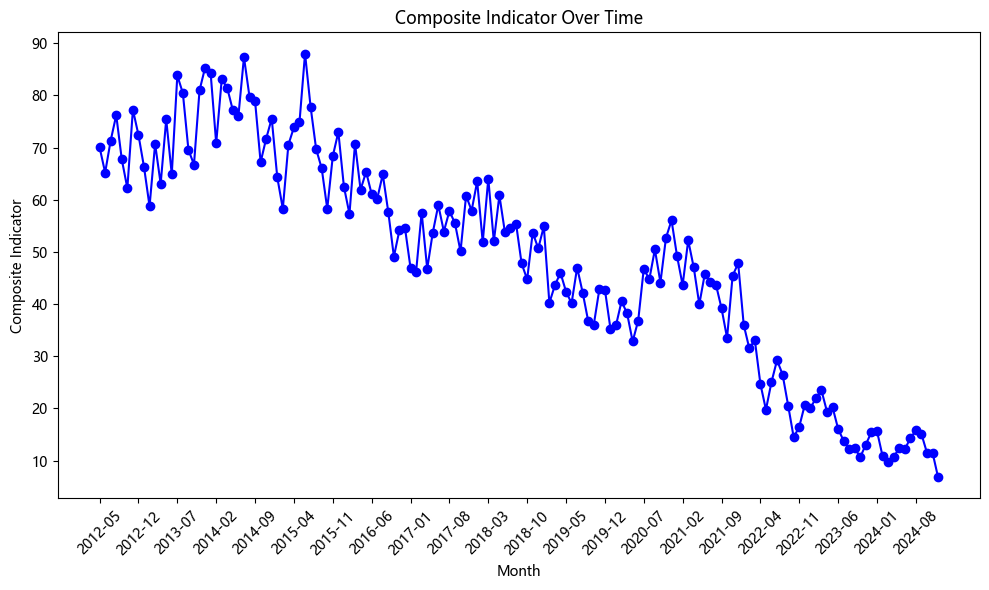

In [58]:
dtw_df['Composite Indicator'] = dtw_df.sum(axis=1)

# Plot the Composite Indicator over time (months)
plt.figure(figsize=(10, 6))
plt.plot(dtw_df.index, dtw_df['Composite Indicator'], marker='o', linestyle='-', color='b')

# Adding title and labels
plt.title('Composite Indicator Over Time')
plt.xlabel('Month')
plt.ylabel('Composite Indicator')

# Rotate x-axis labels for better readability
plt.xticks(dtw_df.index[::7], rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [59]:
dtw_df.head()

,10-year China Government Bond Yield,CSI 300,CSI 2000,USDCNH,Nanhua Industrial Index,Nanhua Commodity Index,Total A-share turnover,Composite Indicator
2012-05,12.602156,6.776139,3.346838,16.034498,11.756275,13.117073,6.437357,70.070335
2012-06,11.045175,6.756457,3.302499,14.083933,11.345320,12.475588,6.192433,65.201406
2012-07,11.537337,8.129864,3.992053,15.296457,12.267172,13.399641,6.734904,71.357429
2012-08,12.460840,9.045549,4.255307,16.037307,13.186672,14.187163,7.046452,76.219289
2012-09,11.699866,8.262086,3.771160,14.642722,11.079669,12.057447,6.215365,67.728314


We can perform similar operations for all months as shown in the above chart (which we will elaborate on in the future), identifying the most relevant months for portfolio selection and backtesting. However, according to our results, we find that it is a

**However, based on our results, we found that for most months, the closer the months are, the more correlated they tend to be. This is an issue that we need to address in the future.**